In [1]:
from torch import empty, set_grad_enabled
set_grad_enabled(False) # REQUIRED

## 1. Generating the data

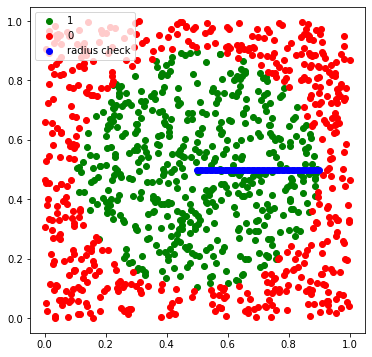

In [2]:
from utils import generate_dataset, show_dataset

X_train, y_train, X_test, y_test = generate_dataset(1000)
show_dataset(X_train, y_train)

### Testing linear regression

Text(0.5, 1.0, 'Error on b')

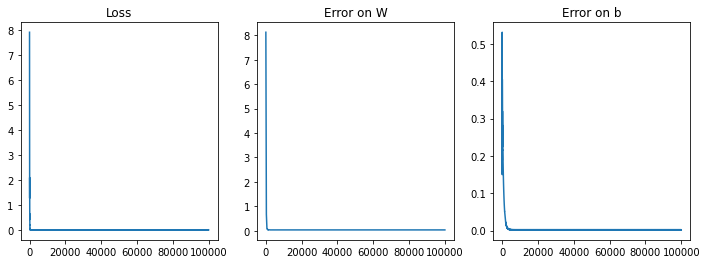

In [3]:
from module import Linear, ReLU, Tanh, LossMSE
import matplotlib.pyplot as plt




n_samples = 1000
input_dim = 20
output_dim = 2

x0 = empty((n_samples, input_dim)).uniform_()


y = empty((n_samples, output_dim)).uniform_()


W = empty((output_dim, input_dim)).normal_(0, 1)
b = empty(output_dim).normal_(0, 1)
y = empty((n_samples, output_dim)).zero_() 


for i in range(n_samples):
    x = x0[i]
    y[i] = W.mv(x) + b
    
y += 0.05*empty(y.shape).normal_(0, 1)
    
ll = Linear(input_dim, output_dim)
LS = LossMSE()


losses, d_w, d_b = [], [], []


nb_epochs = 10000
mini_batch_size = 100
lr = 1e-1/n_samples*mini_batch_size



for epoch in range(nb_epochs):
    ll.zero_grad()
    for i in range(0, x0.size(0), mini_batch_size):
        input_ = x0.narrow(0, i, mini_batch_size)
        target = y.narrow(0, i, mini_batch_size)
        x2 = ll.forward(input_)
        
        loss = LS.forward(x2, target)

        grad_output = LS.backward()
        grad_input = ll.backward(grad_output)
        

        ll.W -= lr*ll.grad_W
        ll.b -= lr*ll.grad_b
        losses.append(loss.item())
        d_w.append((W-ll.W).norm())
        d_b.append((b-ll.b.squeeze()).norm())
    
f, ax = plt.subplots(1, 3, figsize = (12, 4))

ax[0].plot(losses)
ax[0].set_title('Loss')
ax[1].plot(d_w)
ax[1].set_title('Error on W')
ax[2].plot(d_b)
ax[2].set_title('Error on b')

In [4]:
W - ll.W

tensor([[-0.0009, -0.0056,  0.0007,  0.0114,  0.0071, -0.0053,  0.0041,  0.0019,
         -0.0038, -0.0084,  0.0054, -0.0038,  0.0009, -0.0051, -0.0078, -0.0100,
          0.0010,  0.0084,  0.0026,  0.0068],
        [ 0.0019, -0.0003, -0.0027,  0.0014,  0.0011, -0.0003,  0.0134,  0.0034,
         -0.0039,  0.0047,  0.0051,  0.0038,  0.0007, -0.0044, -0.0094, -0.0112,
          0.0025, -0.0018, -0.0023,  0.0041]])

In [5]:
b - ll.b

tensor([-0.0003, -0.0026])

In [6]:
d_w[-1], d_b[-1]

(tensor(0.0354), tensor(0.0026))

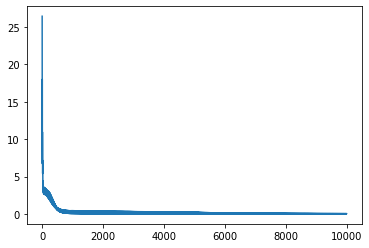

In [7]:
LS = LossMSE()

hidden_dim = 5
L1 = Linear(input_dim, hidden_dim)
R = ReLU()
L2 = Linear(hidden_dim, output_dim)

losses, d_w, d_b = [], [], []


nb_epochs = 1000
mini_batch_size = 100
lr = 1e-1/n_samples*mini_batch_size



for epoch in range(nb_epochs):
    L1.zero_grad()
    L2.zero_grad()
    for i in range(0, x0.size(0), mini_batch_size):
        input_ = x0.narrow(0, i, mini_batch_size)
        target = y.narrow(0, i, mini_batch_size)
        
        # forward pass
        x1 = L1.forward(input_)
        s1 = R.forward(x1)
        x2 = L2.forward(s1)
        loss = LS.forward(x2, target)
        # backward pass
        grad_x2 = LS.backward()
        grad_s1 = L2.backward(grad_x2)
        grad_x1 = R.backward(grad_s1)
        grad_input = L1.backward(grad_x1)
        

        L1.W -= lr*L1.grad_W
        L1.b -= lr*L1.grad_b
        
        L2.W -= lr*L2.grad_W
        L2.b -= lr*L2.grad_b
        
        losses.append(loss.item())
    

plt.plot(losses)


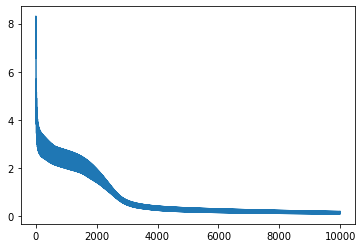

In [8]:
from module import Sequential 


hidden_1, hidden_2 = 6, 3
model = Sequential(Linear(input_dim, hidden_1), 
                   Tanh(),
                   Linear(hidden_1, hidden_2), 
                   Tanh(),
                   Linear(hidden_2, output_dim))


losses, d_w, d_b = [], [], []


nb_epochs = 1000
mini_batch_size = 100
lr = 1e-2/n_samples*mini_batch_size



for epoch in range(nb_epochs):
    model.zero_grad()
    
    for i in range(0, x0.size(0), mini_batch_size):
        input_ = x0.narrow(0, i, mini_batch_size)
        target = y.narrow(0, i, mini_batch_size)
        
        # forward pass
        out = model.forward(input_)
        loss = LS.forward(out, target)
        # backward pass
        grad_output = LS.backward()
        grad_input = model.backward(grad_output)
        
        for layer in model.layers:
            if layer.trainable:
                layer.W -= lr*layer.grad_W
                layer.b -= lr*layer.grad_b
        
        losses.append(loss.item())
    

plt.plot(losses)


### Testing on MNIST

In [9]:
from dlc_practical_prologue import load_data

train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True, flatten = True)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [10]:
train_input.shape, train_target.shape

(torch.Size([1000, 784]), torch.Size([1000, 10]))

In [92]:
from torch import empty

class Module(object):
    """ Base class. """
    def __init__(self):
        self.trainable = False

    def forward(self , *input_):
        raise NotImplementedError
    def backward(self , *gradwrtoutput):
        raise NotImplementedError
    def param(self):
        return []


class Activation(Module):
    """ Generic class for an activation function. 
    
    Methods
    -------
    forward(input_)
        Performs the forward pass for a generic activation function.
        
    backward(grad_output)
        Performs the backward pass for a generic activation function.
    """
    
    def forward(self, input_):
        """ Performs the forward pass for a generic activation function. 
        Stores the input_ for the backward pass and call the function itself. 
        
        Parameters
        ----------
        input_: torch.Tensor (any shape, typically (batch_size, dimension))
            The input to the activation function
            
            
        Returns
        -------
        output: torch.Tensor(same shape as input_)
            The output after passing through the activation
        """
        
        output = self.f(input_)
        self.input = input_
        
        return output

    def backward(self, grad_output):
        """ Performs the backward pass for a generic activation function. 
         
        
        Parameters
        ----------
        grad_output: torch.Tensor (same shape as self.input)
            The gradient at the output of the activation function
            
            
        Returns
        -------
        grad_input: torch.Tensor(same shape as self.input)
            The gradient at the input of the activation function
        """
        
        grad_input = grad_output *  self.f_prime(self.input)
        
        return grad_input
    
    @staticmethod
    def f(self , *input_):
        raise NotImplementedError
    
    @staticmethod
    def f_prime(self , *input_):
        raise NotImplementedError



class ReLU(Activation):
    """ Rectified Linear Unit class.
    Overrides f and f_prime.
    
    Methods
    -------
    f(x)
        Apply the ReLU function to x.
        
    f_prime(x)
        Apply the derivative of ReLU to x.
    """
    
    @staticmethod
    def f(x):
        """ Applies the ReLU function to x.
         
        
        Parameters
        ----------
        x: torch.Tensor (any shape, typically (batch_size, dimension))
            The input to the ReLU function
            
            
        Returns
        -------
        y: torch.Tensor(same shape as x)
            The result of applying ReLU to x
        """
        
        y = x.clamp(min = 0)
        
        return y

    @staticmethod
    def f_prime(x):
        """ Applies the derivative of ReLU to x.
         
        
        Parameters
        ----------
        x: torch.Tensor (any shape, typically (batch_size, dimension))
            The input to the ReLU derivative
            
            
        Returns
        -------
        y: torch.Tensor(same shape as x)
            The result of applying the derivative of ReLU to x
        """
        
        y = (x.sign()+1)/2
        
        return y


class Tanh(Activation):
    """ Hyperbolic tangent class.
    Overrides f and f_prime.
    
    Methods
    -------
    f(x)
        Apply the Tanh function to x.
        
    f_prime(x)
        Apply the derivative of Tanh to x.
    """
    
    @staticmethod
    def f(x):
        """ Applies the Tanh function to x.
         
        
        Parameters
        ----------
        x: torch.Tensor (any shape, typically (batch_size, dimension))
            The input to the Tanh function
            
            
        Returns
        -------
        y: torch.Tensor(same shape as x)
            The result of applying Tanh to x
        """
        y = x.tanh()
        
        return y

    @staticmethod
    def f_prime(x):
        """ Applies the derivative of Tanh to x.
         
        
        Parameters
        ----------
        x: torch.Tensor (any shape, typically (batch_size, dimension))
            The input to the Tanh derivative
            
            
        Returns
        -------
        y: torch.Tensor(same shape as x)
            The result of applying the derivative of Tanh to x
        """
        
        y = 4 * (x.exp() + x.mul(-1).exp()).pow(-2)
        
        return y

class LossMSE(Module):
    """ Mean Squared Error Loss. 
    
    Methods
    -------
    forward(prediction, target)
        Computes the MSE of a prediction given a target.
        
    backward()
        Computes the gradient at the input of the loss function
    """
    
    def forward(self , prediction, target):
        """ Computes the MSE of a prediction given a target.
        Stores the error for the backward pass. 
        
        Parameters
        ----------
        prediction: torch.Tensor of shape (batch_size, dimension)
            The predicted vectors
        target: torch.Tensor, same shape as prediction
            The target vectors
            
        Returns
        -------
        loss: torch.Tensor of shape []
            The sum of the MSE loss of each batch
        """
        
        error = target - prediction
        self.error = error
        self.d = prediction.shape[1]
        loss = error.pow(2).sum()/self.d

        return loss

    def backward(self):
        """ Computes the derivative of the MSE loss with respect to its input.
         
        Returns
        -------
        grad_input: torch.Tensor(same shape as self.error)
            The gradient with respect to the input of the loss function
        """
        
        return -2*self.error/self.d

class LossBCE(Module):
    """ Binary Cross Entropy Loss. 
    
    Methods
    -------
    forward(prediction, target)
        Computes the BCE of a prediction given a target.
        
    backward()
        Computes the gradient at the input of the loss function
    """
    
    def forward(self , prediction, target):
        """ Computes the BCE of a prediction given a target.
        Stores the prediction and target for the backward pass. 
        
        Parameters
        ----------
        prediction: torch.Tensor of shape (batch_size, 1)
            The predicted 1D vectors
        target: torch.Tensor, same shape as prediction
            The target 1D vectors, expected to be 0 or 1
            
        Returns
        -------
        loss: torch.Tensor of shape []
            The sum of the MSE loss of each batch
        """
        
        self.p = prediction
        self.t = target
        loss = (prediction.logaddexp(empty(prediction.shape).zero_()) - target*prediction).sum()/target.shape[1]

        return loss

    def backward(self):
        """ Computes the derivative of the MSE loss with respect to its input.
         
        Returns
        -------
        grad_input: torch.Tensor(same shape as self.error)
            The gradient with respect to the input of the loss function
        """
        
        exp = self.p.exp()
        grad_input = (exp/(1+exp) - self.t)/self.t.shape[1]

        return grad_input


class Linear(Module):
    """ Fully Connected Layer. 
    
    Methods
    -------
    forward(prediction, target)
        Computes the forward pass.
        
    backward()
        Computes the backward pass.
    """
    
    def __init__(self, input_dim, output_dim, sigma = 1.):
        """ Constructor
        Intializes the weight matrix and bias vector, set their gradient to 0 and declares the layer as trainable.
        
        Parameters
        ----------
        input_dim: int
            The dimension of the input vectors
        output_dim: int
            The dimension of the output vectors
        sigma: float
            The standard deviation of the normal distribution to initialize weights and biases.
        """
        
        self.W = empty((output_dim, input_dim)).normal_(0, sigma)
        self.b = empty(output_dim).normal_(0, sigma)
        self.zero_grad()
        self.trainable = True

    def zero_grad(self):
        """ Re-set the gradients og the weights and biases to 0. """
        self.grad_W = empty(self.W.shape).zero_()
        self.grad_b = empty(self.b.shape).zero_()


    def forward(self, input_):
        """ Computes the forward pass.
        Stores the input_ for the backward pass. 
        
        Parameters
        ----------
        input_: torch.Tensor of shape (batch_size, input_dim)
            The input vectors
            
        Returns
        -------
        output: torch.Tensor of shape (batch_size, output_dim)
            The output vectors
        """
        
        self.input = input_
        output = (self.W.mm(input_.T) + self.b.unsqueeze(1)).T
        print('f', input_.shape, output.shape)
        return output


    def backward(self, grad_output):
        """ Computes the backward pass.
        
        Parameters
        ----------
        grad_output: torch.Tensor of shape (batch_size, input_dim)
            The predicted 1D vectors
            
        Returns
        -------
        grad_input: torch.Tensor of shape []
            The sum of the MSE loss of each batch
        """
        
        
        grad_input = grad_output.mm(self.W)
        self.grad_W += grad_output.T.mm(self.input)
        self.grad_b += grad_output.T.sum(axis = 1)
        print('gradient', grad_input.shape, grad_output.shape)

        return grad_input


    def param(self):
        return [(self.W, self.grad_W), (self.b, self.grad_b)]

class Sequential(Module):
    def __init__(self, *layers):
        self.layers = layers

    def forward(self , input_):
        output = input_
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def backward(self , grad_output):
        grad_input = grad_output
        for layer in reversed(self.layers):
            grad_input = layer.backward(grad_input)
        return grad_input

    def zero_grad(self):
        for layer in self.layers:
            if layer.trainable:
                layer.zero_grad()

    def param(self):
        return []


In [93]:
LS = LossBCE()

input_dim, h1, h2, h3, output_dim = 28**2, 100, 50, 20, 10

model = Sequential(Linear(input_dim, h1), 
                   Tanh(),
                   Linear(h1, h2), 
                   Tanh(),
                   Linear(h2, h3),
                   Tanh(),
                   Linear(h3, output_dim))


losses, d_w, d_b = [], [], []


nb_epochs = 1000
mini_batch_size = 50
lr = 1e-2/n_samples*mini_batch_size



for epoch in range(nb_epochs):
    
    model.zero_grad()
    
    for i in range(0, train_input.size(0), mini_batch_size):
        input_ = train_input.narrow(0, i, mini_batch_size)
        target = train_target.narrow(0, i, mini_batch_size)
        
        # forward pass
        out = model.forward(input_)
        loss = LS.forward(out, target)
        # backward pass
        grad_output = LS.backward()
        grad_input = model.backward(grad_output)
        
        for layer in model.layers:
            if layer.trainable:
                layer.W -= lr*layer.grad_W
                layer.b -= lr*layer.grad_b
        
        losses.append(loss.item())
        
    if epoch %50 == 1:
        prediction_train = model.forward(train_input).argmax(axis = 1)
        target_train = train_target.argmax(axis = 1)
        accuracy_train = (prediction_train == target_train).sum()/len(target_train)
        prediction_test = model.forward(test_input).argmax(axis = 1)
        target_test = test_target.argmax(axis = 1)
        accuracy_test = (prediction_test == target_test).sum()/len(target_test)
        print('Epoch {:d}: loss = {:.3f}, accuracy = {:.1f}% (train)/{:.1f}% (test))'.format(epoch, loss.item(),
                                                                                             accuracy_train*100, 
                                                                                             accuracy_test*100))
    
plt.plot(losses)

f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10]

f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10]

gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) to

f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10]

gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 1

f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10]

f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784])

gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 1

f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10]

gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784

gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784

f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50

f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 50]) torch.Size([50, 20])
gradient torch.Size([50, 100]) torch.Size([50, 50])
gradient torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 784]) torch.Size([50, 100])
f torch.Size([50, 100]) torch.Size([50, 50])
f torch.Size([50, 50]) torch.Size([50, 20])
f torch.Size([50, 20]) torch.Size([50, 10])
gradient torch.Size([50, 20]) torch.Size([50, 10]

KeyboardInterrupt: 

In [ ]:

set_grad_enabled(False) # REQUIRED
manual_seed(3)

n_samples = 1000
X_train, y_train, X_test, y_test = generate_dataset(n_samples)

input_dim, h1, h2, h3, output_dim = 2, 25, 25, 25, 1



def train(model, nb_epochs, LS, lr, mini_batch_size):
    for epoch in range(nb_epochs):
        model.zero_grad()
        for i in range(0, X_train.size(0), mini_batch_size):
            input_ = X_train.narrow(0, i, mini_batch_size)
            target = y_train.narrow(0, i, mini_batch_size)

            # forward pass
            out = model.forward(input_)
            loss = LS.forward(out, target)
            # backward pass
            grad_output = LS.backward()

            grad_input = model.backward(grad_output)

            for layer in model.layers:
                if layer.trainable:
                    layer.W -= lr*layer.grad_W
                    layer.b -= lr*layer.grad_b

        pred_train = model.forward(X_train) > 0.5

        target_train = y_train
        accuracy_train = (pred_train == target_train).sum()/len(target_train)
        pred_test = model.forward(X_test) > 0.5
        target_test = y_test
        accuracy_test = (pred_test == target_test).sum()/len(target_test)
        print('Epoch {:d}: loss = {:.3f}, accuracy = {:.1f}% (train)/{:.1f}% (test))'.format(epoch, loss.item(),
                                                                                             accuracy_train*100,
                                                                                             accuracy_test*100))
activation = Tanh
model = Sequential(Linear(input_dim, h1),
                   activation(),
                   Linear(h1, h2),
                   activation(),
                   Linear(h2, h3),
                   activation(),
                   Linear(h3, output_dim))
LS = LossMSE()
nb_epochs = 100
mini_batch_size = 50
lr = 1e-2/n_samples*mini_batch_size # 1e-2 for MSE

train(model, nb_epochs, LS, lr, mini_batch_size)



activation = ReLU
model = Sequential(Linear(input_dim, h1),
                   activation(),
                   Linear(h1, h2),
                   activation(),
                   Linear(h2, h3),
                   activation(),
                   Linear(h3, output_dim))
LS = LossBCE()
nb_epochs = 100
mini_batch_size = 50
lr = 1e-2/n_samples*mini_batch_size # 1e-2 for MSE

train(model, nb_epochs, LS, lr, mini_batch_size)
